In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import threading
import time
import shutil

import os
import sys
import os
from joblib import Parallel, delayed

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from astroquery.hips2fits import hips2fits
from astropy.wcs import WCS

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from utils.download_data.h2f_download_functions import get_augmented_multires
from utils.sersic_functions import sersic_profile
from utils.custom_datasets import DelightClassic

In [8]:
def augment_dataframe(data_frame, percentaje=0.01, n_jobs=-1):
    """
    Duplica filas de un DataFrame según el número de augmentaciones calculado
    con un perfil de Sérsic.
    """
    def compute_num_aug(row):
        sersic_img = sersic_profile(
            image_shape=(600, 600),
            x_center=299, y_center=299,
            Re_arcsec=row["rSerRadius"],
            b_over_a=row["rSerAb"],
            theta_deg=row["rSerPhi"],
            pixel_scale=0.25,
            Ie=1.0,
            n=4
        )
        n_pix = np.count_nonzero(sersic_img) * percentaje
        return int(np.ceil(n_pix))

    nums = Parallel(n_jobs=n_jobs)(
        delayed(compute_num_aug)(row) for _, row in data_frame.iterrows()
    )
    data_frame = data_frame.copy()
    data_frame["num_augmentations"] = nums

    data_frame_aug = data_frame.loc[
       data_frame.index.repeat(data_frame["num_augmentations"])
    ].reset_index(drop=True)

    return data_frame_aug

In [9]:
df = pd.read_csv("/home/acontreras/PRISM/data/SERSIC/df_pasquet_train.csv")
df = augment_dataframe(df, percentaje=0.0002)

In [4]:
data = np.load("/home/acontreras/PRISM/data/SERSIC/X_train_autolabeling_delight_01_percent_1.npz")
sn_pos = data["pos"]
imgs = data["imgs"]

In [5]:
imgs.shape

(29053, 5, 1, 30, 30)

In [6]:
mask = (imgs.sum((3,4))==0).any((1,2))
mask.sum()

0

In [67]:
data2 = np.load("/home/acontreras/PRISM/data/SERSIC/train_delight.npz")
pos2 = data2["pos"]

In [68]:
data3 = np.load("/home/acontreras/PRISM/data/SERSIC/X_train_autolabeling_delight_01_percent_1.npz")
pos3 = data3["pos"]

In [69]:
distances = np.linalg.norm(sn_pos, axis=1)
distances2 = np.linalg.norm(pos2, axis=1)
distances3 = np.linalg.norm(pos3, axis=1)

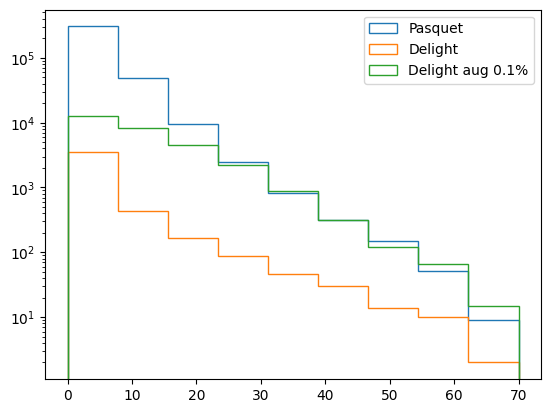

In [70]:
bins=np.linspace(0,70,10)
plt.hist(distances*0.25, bins=bins, label="Pasquet", histtype="step")
plt.hist(distances2*0.25, bins=bins, label="Delight", histtype="step")
plt.hist(distances3*0.25, bins=bins, label="Delight aug 0.1%", histtype="step")

plt.legend()
plt.yscale("log")